## **1.1 Load Libraries & Create Output Dirs**

In [1]:
# === 1. Import Libraries ===
import os
import random
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# === 2. Define Project Paths ===
PHASE_NUMBER = 1

RESULT_DIR = f"result/phase_{PHASE_NUMBER}"
PLOT_DIR = os.path.join(RESULT_DIR, "plot")
DATA_DIR = os.path.join(RESULT_DIR, "data")

os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print(f"Phase {PHASE_NUMBER} directories created/verified:")
print(f"  Plots: {PLOT_DIR}")
print(f"  Data:  {DATA_DIR}")

# === 3. Set Random Seed for Reproducibility ===
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
print(f"Random seed set to {SEED}")

# === 4. Matplotlib Plotting Settings (for IEEE) ===
def setup_ieee_plots():
    """Apply consistent, professional plot settings for IEEE publication."""
    plt.rcParams.update({
        'figure.figsize': (8, 5),
        'figure.dpi': 300,
        'font.family': 'serif',
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2,
        'lines.markersize': 5,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
        'axes.grid': True,
    })
    print("IEEE plot settings applied.")

setup_ieee_plots()

Phase 1 directories created/verified:
  Plots: result/phase_1\plot
  Data:  result/phase_1\data
Random seed set to 42
IEEE plot settings applied.


## **1.2 Stream-Load Raw CSV (No Header) & Assign Columns**

In [2]:
df = pd.read_csv('./data/data.csv', header=None, names=['Current', 'Voltage'])

print(f"Total rows loaded: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
print(df.head())

Total rows loaded: 22,714,175
Columns: ['Current', 'Voltage']

First 5 rows:
   Current  Voltage
0      0.0  3.44511
1      0.0  3.44495
2      0.0  3.44495
3      0.0  3.44495
4      0.0  3.44511


## **1.3 Basic Sanity Checks (Row Counts, Zero/± Current)**

In [4]:
total_rows = len(df)
zero_current = (df['Current'] == 0.0).sum()
positive_current = (df['Current'] > 0.0).sum()
negative_current = (df['Current'] < 0.0).sum()

print(f"Total rows: {total_rows:,}")
print(f"Zero current samples: {zero_current:,} ({100*zero_current/total_rows:.2f}%)")
print(f"Positive current samples: {positive_current:,} ({100*positive_current/total_rows:.2f}%)")
print(f"Negative current samples: {negative_current:,} ({100*negative_current/total_rows:.2f}%)")
print(f"\nSum check: {zero_current + positive_current + negative_current} == {total_rows}: {zero_current + positive_current + negative_current == total_rows}")

Total rows: 22,714,175
Zero current samples: 10,145,126 (44.66%)
Positive current samples: 8,564,265 (37.70%)
Negative current samples: 4,004,784 (17.63%)

Sum check: 22714175 == 22714175: True


## **1.4 Current/Voltage Preview (Sample Rows & Descriptives)**

In [5]:
# Current and Voltage descriptive statistics
print("Current (A) statistics:")
print(df['Current'].describe())
print(f"\nCurrent min: {df['Current'].min():.4f} A")
print(f"Current max: {df['Current'].max():.4f} A")

# Non-zero current statistics
non_zero_current = df[df['Current'] != 0.0]['Current']
print(f"\nNon-zero current mean: {non_zero_current.mean():.4f} A")
print(f"Non-zero current std: {non_zero_current.std():.4f} A")

print("\n" + "="*50)
print("Voltage (V) statistics:")
print(df['Voltage'].describe())
print(f"\nVoltage min: {df['Voltage'].min():.4f} V")
print(f"Voltage max: {df['Voltage'].max():.4f} V")

Current (A) statistics:
count    2.271418e+07
mean     3.202284e-03
std      1.839635e+00
min     -3.225681e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.572700e-01
max      3.229114e+00
Name: Current, dtype: float64

Current min: -3.2257 A
Current max: 3.2291 A

Non-zero current mean: 0.0058 A
Non-zero current std: 2.4730 A

Voltage (V) statistics:
count    2.271418e+07
mean     3.869404e+00
std      3.486531e-01
min      2.999690e+00
25%      3.460820e+00
50%      4.005720e+00
75%      4.195390e+00
max      4.201343e+00
Name: Voltage, dtype: float64

Voltage min: 2.9997 V
Voltage max: 4.2013 V


## **1.5 Current–Voltage Time Series Overview**


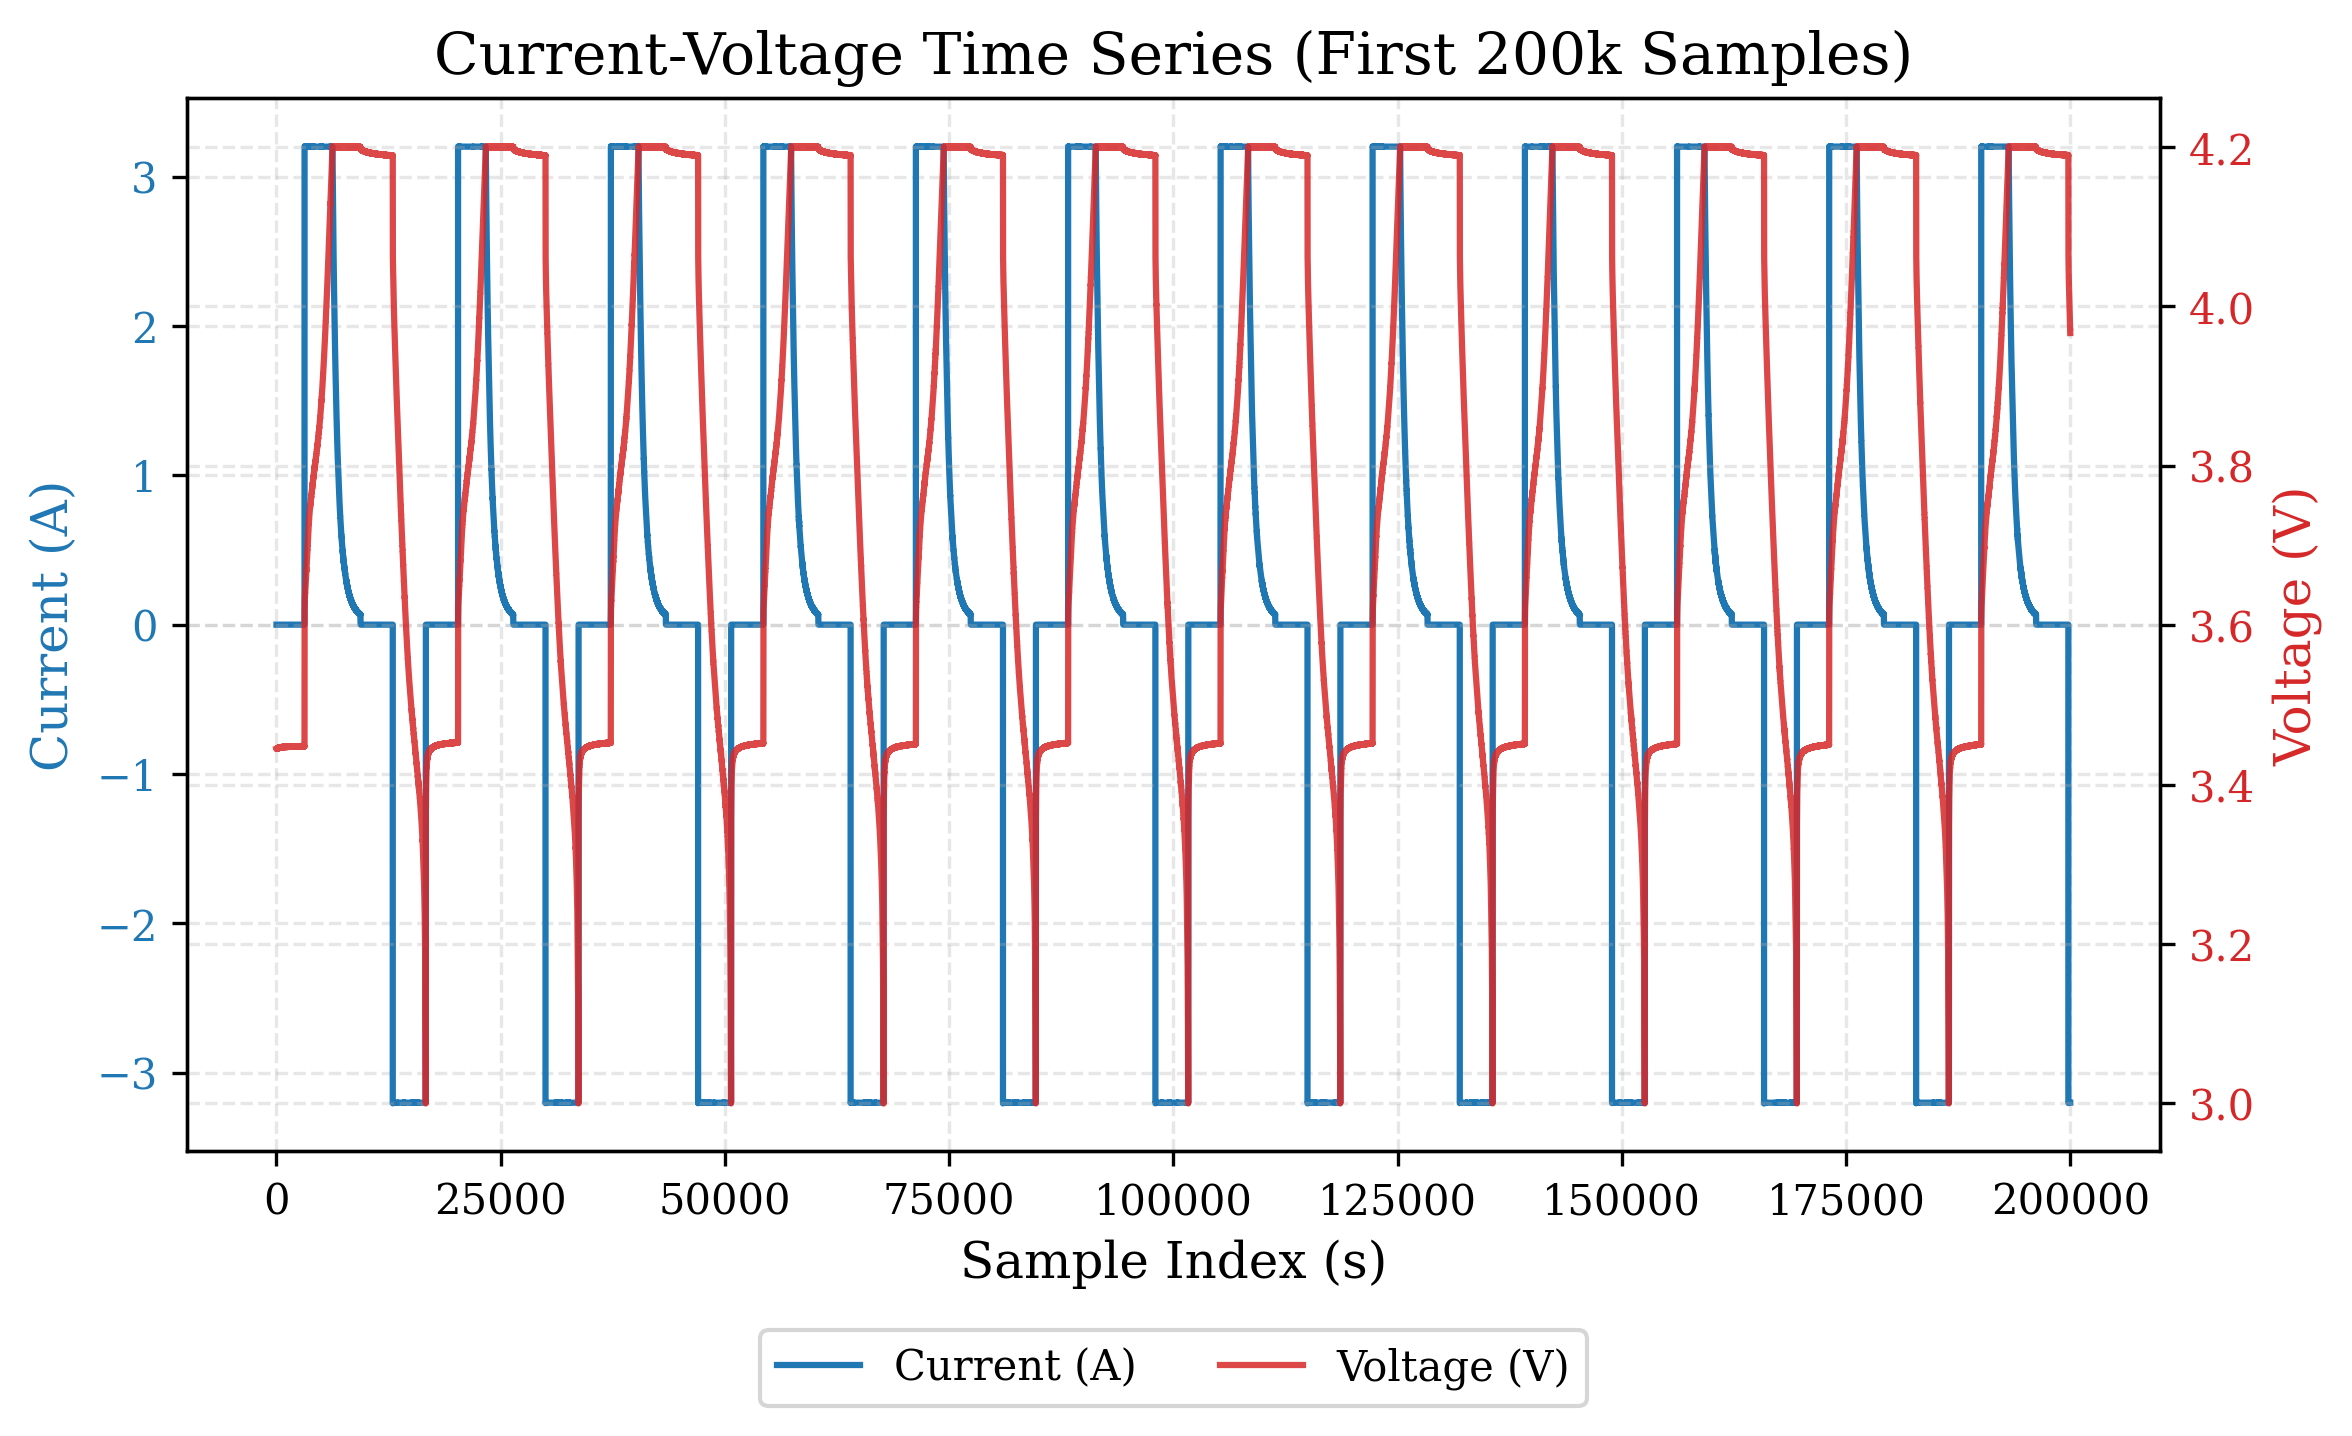

Plot saved to result/phase_1\plot\current_voltage_timeseries.png


In [7]:
window = slice(0, 200_000)
df_slice = df.iloc[window].copy()

fig, ax1 = plt.subplots(figsize=(8, 5))

lns1 = ax1.plot(
    df_slice.index,
    df_slice["Current"],
    color="tab:blue",
    linewidth=1.5,
    label="Current (A)"
)
ax1.set_xlabel("Sample Index (s)")
ax1.set_ylabel("Current (A)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, alpha=0.3, linestyle='--')

ax2 = ax1.twinx()
lns2 = ax2.plot(
    df_slice.index,
    df_slice["Voltage"],
    color="tab:red",
    linewidth=1.5,
    label="Voltage (V)",
    alpha=0.85
)
ax2.set_ylabel("Voltage (V)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

lns = lns1 + lns2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)

plt.title("Current-Voltage Time Series (First 200k Samples)")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "current_voltage_timeseries.png"), bbox_inches='tight')
plt.show()

print(f"Plot saved to {os.path.join(PLOT_DIR, 'current_voltage_timeseries.png')}")

## **1.6 Discharge Segmentation (Identify Continuous Negative-Current Blocks)**

In [8]:
# Identify discharge segments (continuous negative current blocks)
discharge_mask = df['Current'] < 0.0

# Find segment boundaries using diff on the mask
mask_diff = discharge_mask.astype(int).diff()

# Start of discharge: transition from 0 to 1 (False to True)
discharge_starts = df.index[mask_diff == 1].tolist()

# End of discharge: transition from 1 to 0 (True to False)
discharge_ends = df.index[mask_diff == -1].tolist()

# Handle edge cases
if discharge_mask.iloc[0]:
    discharge_starts.insert(0, 0)
if discharge_mask.iloc[-1]:
    discharge_ends.append(len(df) - 1)

print(f"Number of discharge segments detected: {len(discharge_starts)}")
print(f"Number of discharge starts: {len(discharge_starts)}")
print(f"Number of discharge ends: {len(discharge_ends)}")

# Preview first few segments
print("\nFirst 10 discharge segments (start_idx, end_idx, duration_samples):")
for i in range(min(10, len(discharge_starts))):
    start = discharge_starts[i]
    end = discharge_ends[i]
    duration = end - start + 1
    print(f"  Segment {i}: start={start}, end={end}, duration={duration} samples ({duration}s)")

Number of discharge segments detected: 1401
Number of discharge starts: 1401
Number of discharge ends: 1401

First 10 discharge segments (start_idx, end_idx, duration_samples):
  Segment 0: start=12966, end=16645, duration=3680 samples (3680s)
  Segment 1: start=29998, end=33673, duration=3676 samples (3676s)
  Segment 2: start=47011, end=50685, duration=3675 samples (3675s)
  Segment 3: start=64015, end=67690, duration=3676 samples (3676s)
  Segment 4: start=81003, end=84665, duration=3663 samples (3663s)
  Segment 5: start=97996, end=101656, duration=3661 samples (3661s)
  Segment 6: start=114956, end=118612, duration=3657 samples (3657s)
  Segment 7: start=131935, end=135591, duration=3657 samples (3657s)
  Segment 8: start=148907, end=152560, duration=3654 samples (3654s)
  Segment 9: start=165861, end=169516, duration=3656 samples (3656s)


## **1.7 Discharge Segment Duration Distribution**

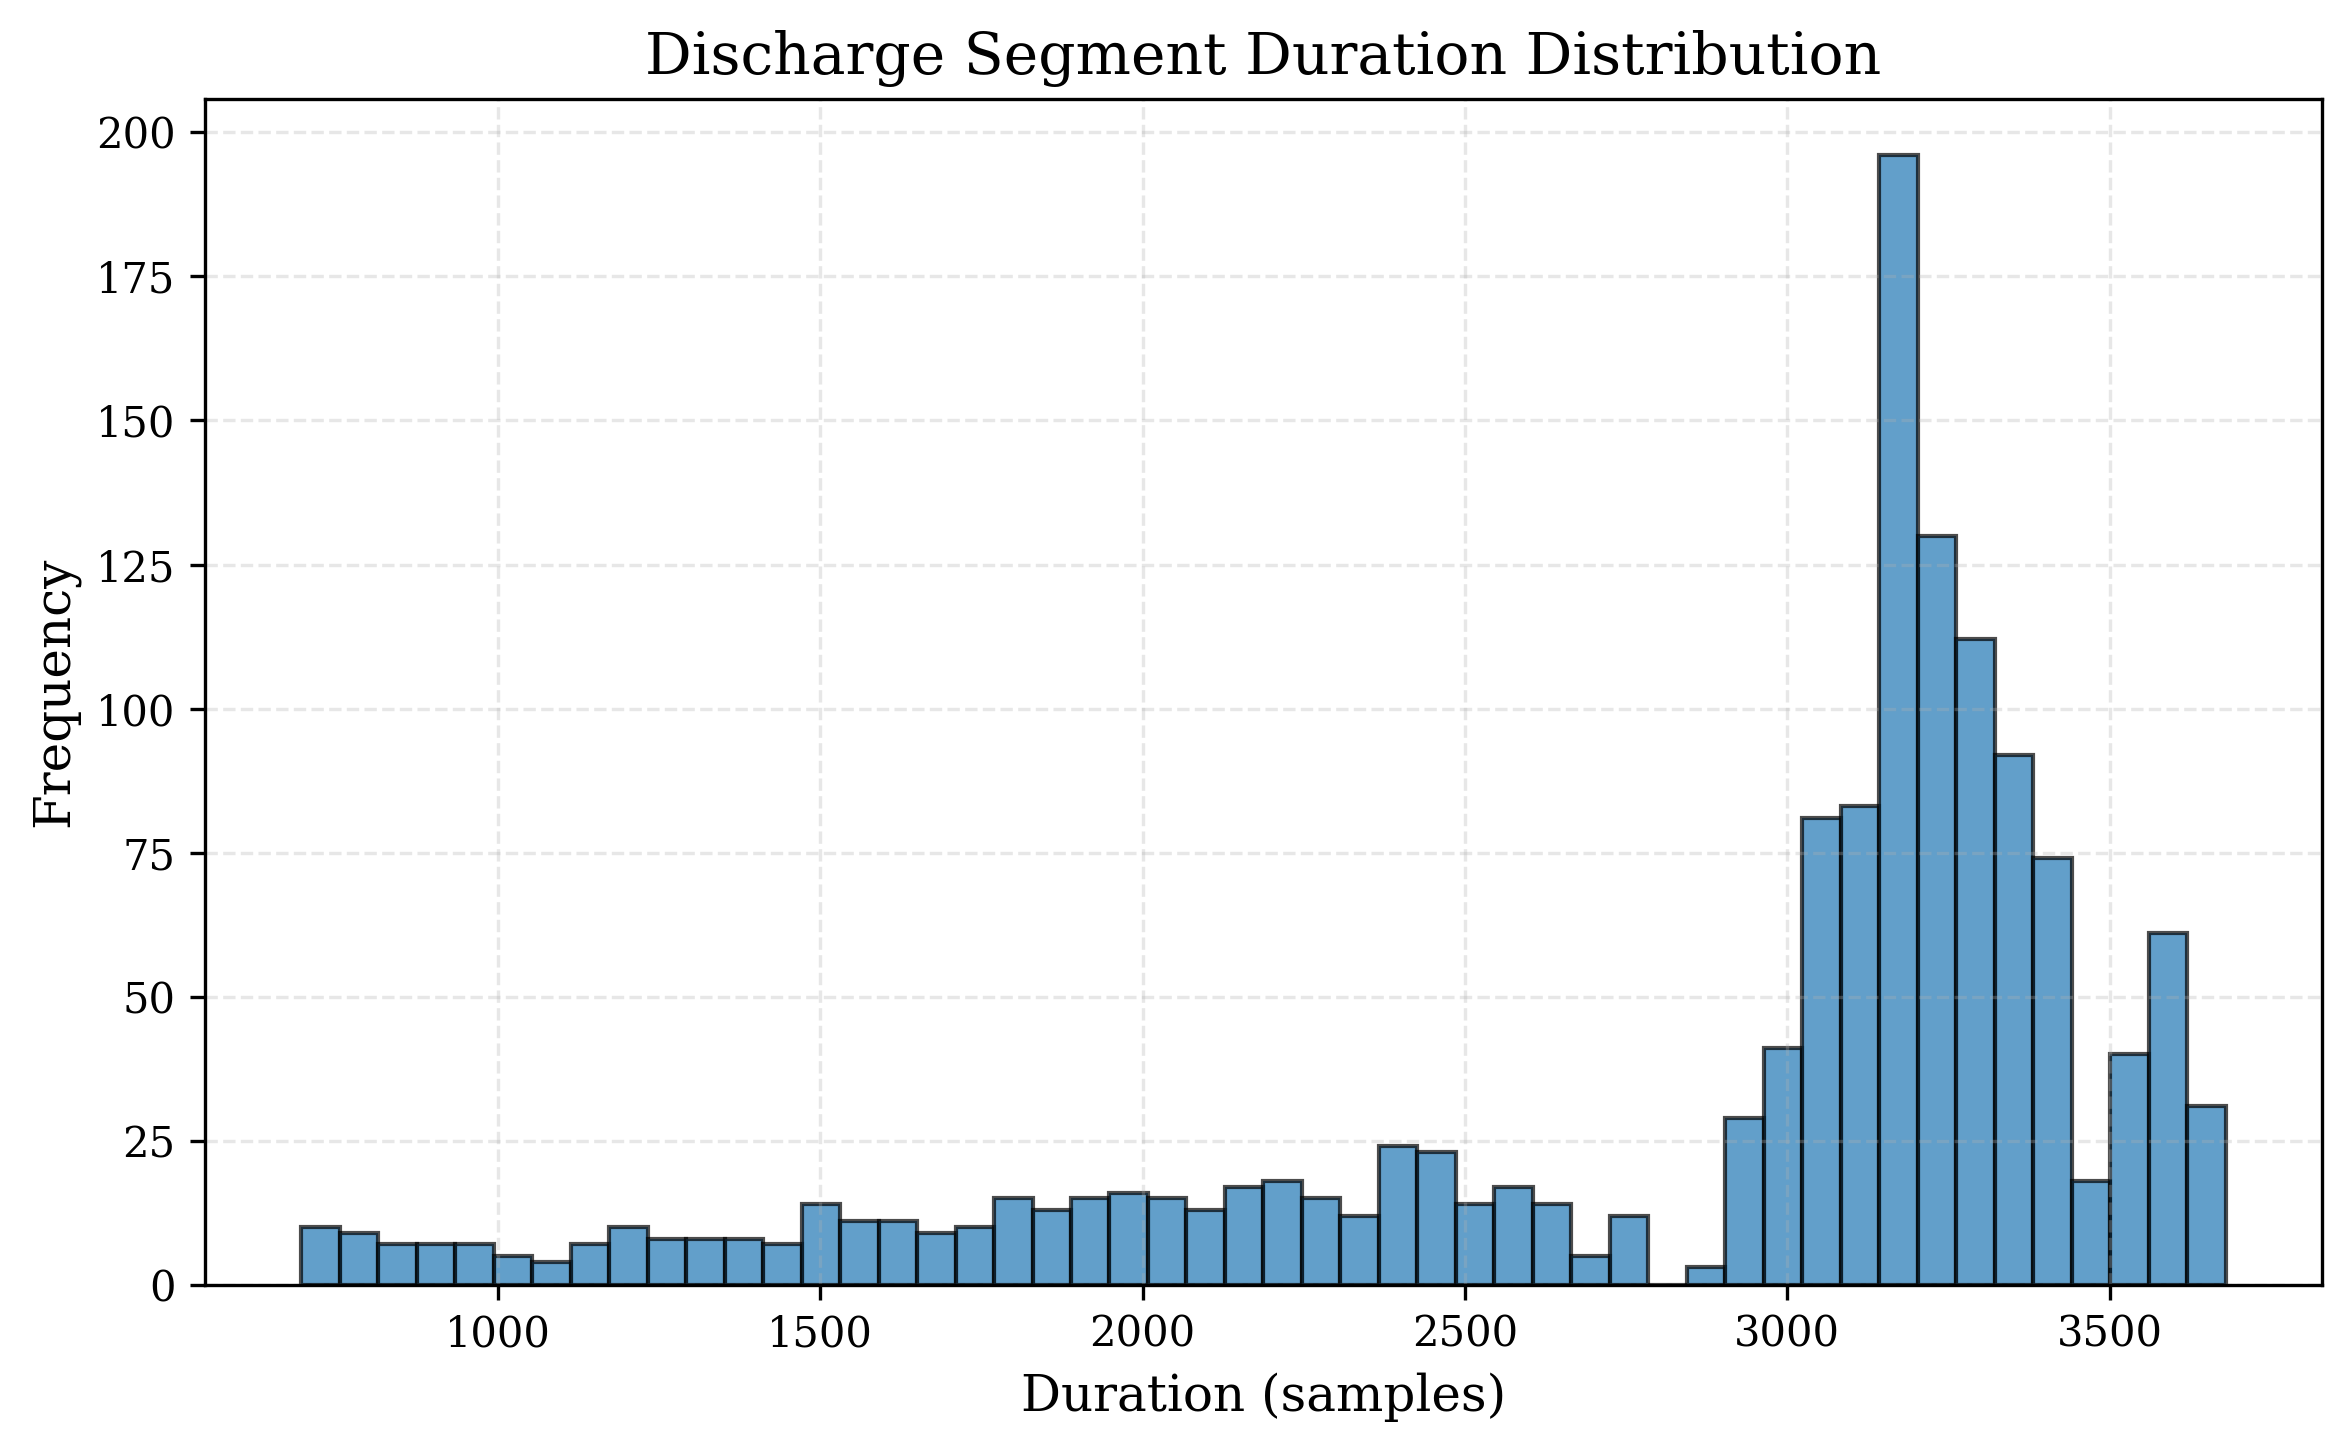

Plot saved to result/phase_1\plot\discharge_duration_histogram.png

Duration statistics:
  Mean: 2859.52 samples
  Median: 3154.00 samples
  Min: 695 samples
  Max: 3680 samples


In [10]:
segment_durations = [discharge_ends[i] - discharge_starts[i] + 1 for i in range(len(discharge_starts))]

plt.figure(figsize=(8, 5))
plt.hist(segment_durations, bins=50, color='tab:blue', alpha=0.7, edgecolor='black')
plt.xlabel('Duration (samples)')
plt.ylabel('Frequency')
plt.title('Discharge Segment Duration Distribution')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "discharge_duration_histogram.png"), bbox_inches='tight')
plt.show()

print(f"Plot saved to {os.path.join(PLOT_DIR, 'discharge_duration_histogram.png')}")
print(f"\nDuration statistics:")
print(f"  Mean: {np.mean(segment_durations):.2f} samples")
print(f"  Median: {np.median(segment_durations):.2f} samples")
print(f"  Min: {np.min(segment_durations)} samples")
print(f"  Max: {np.max(segment_durations)} samples")

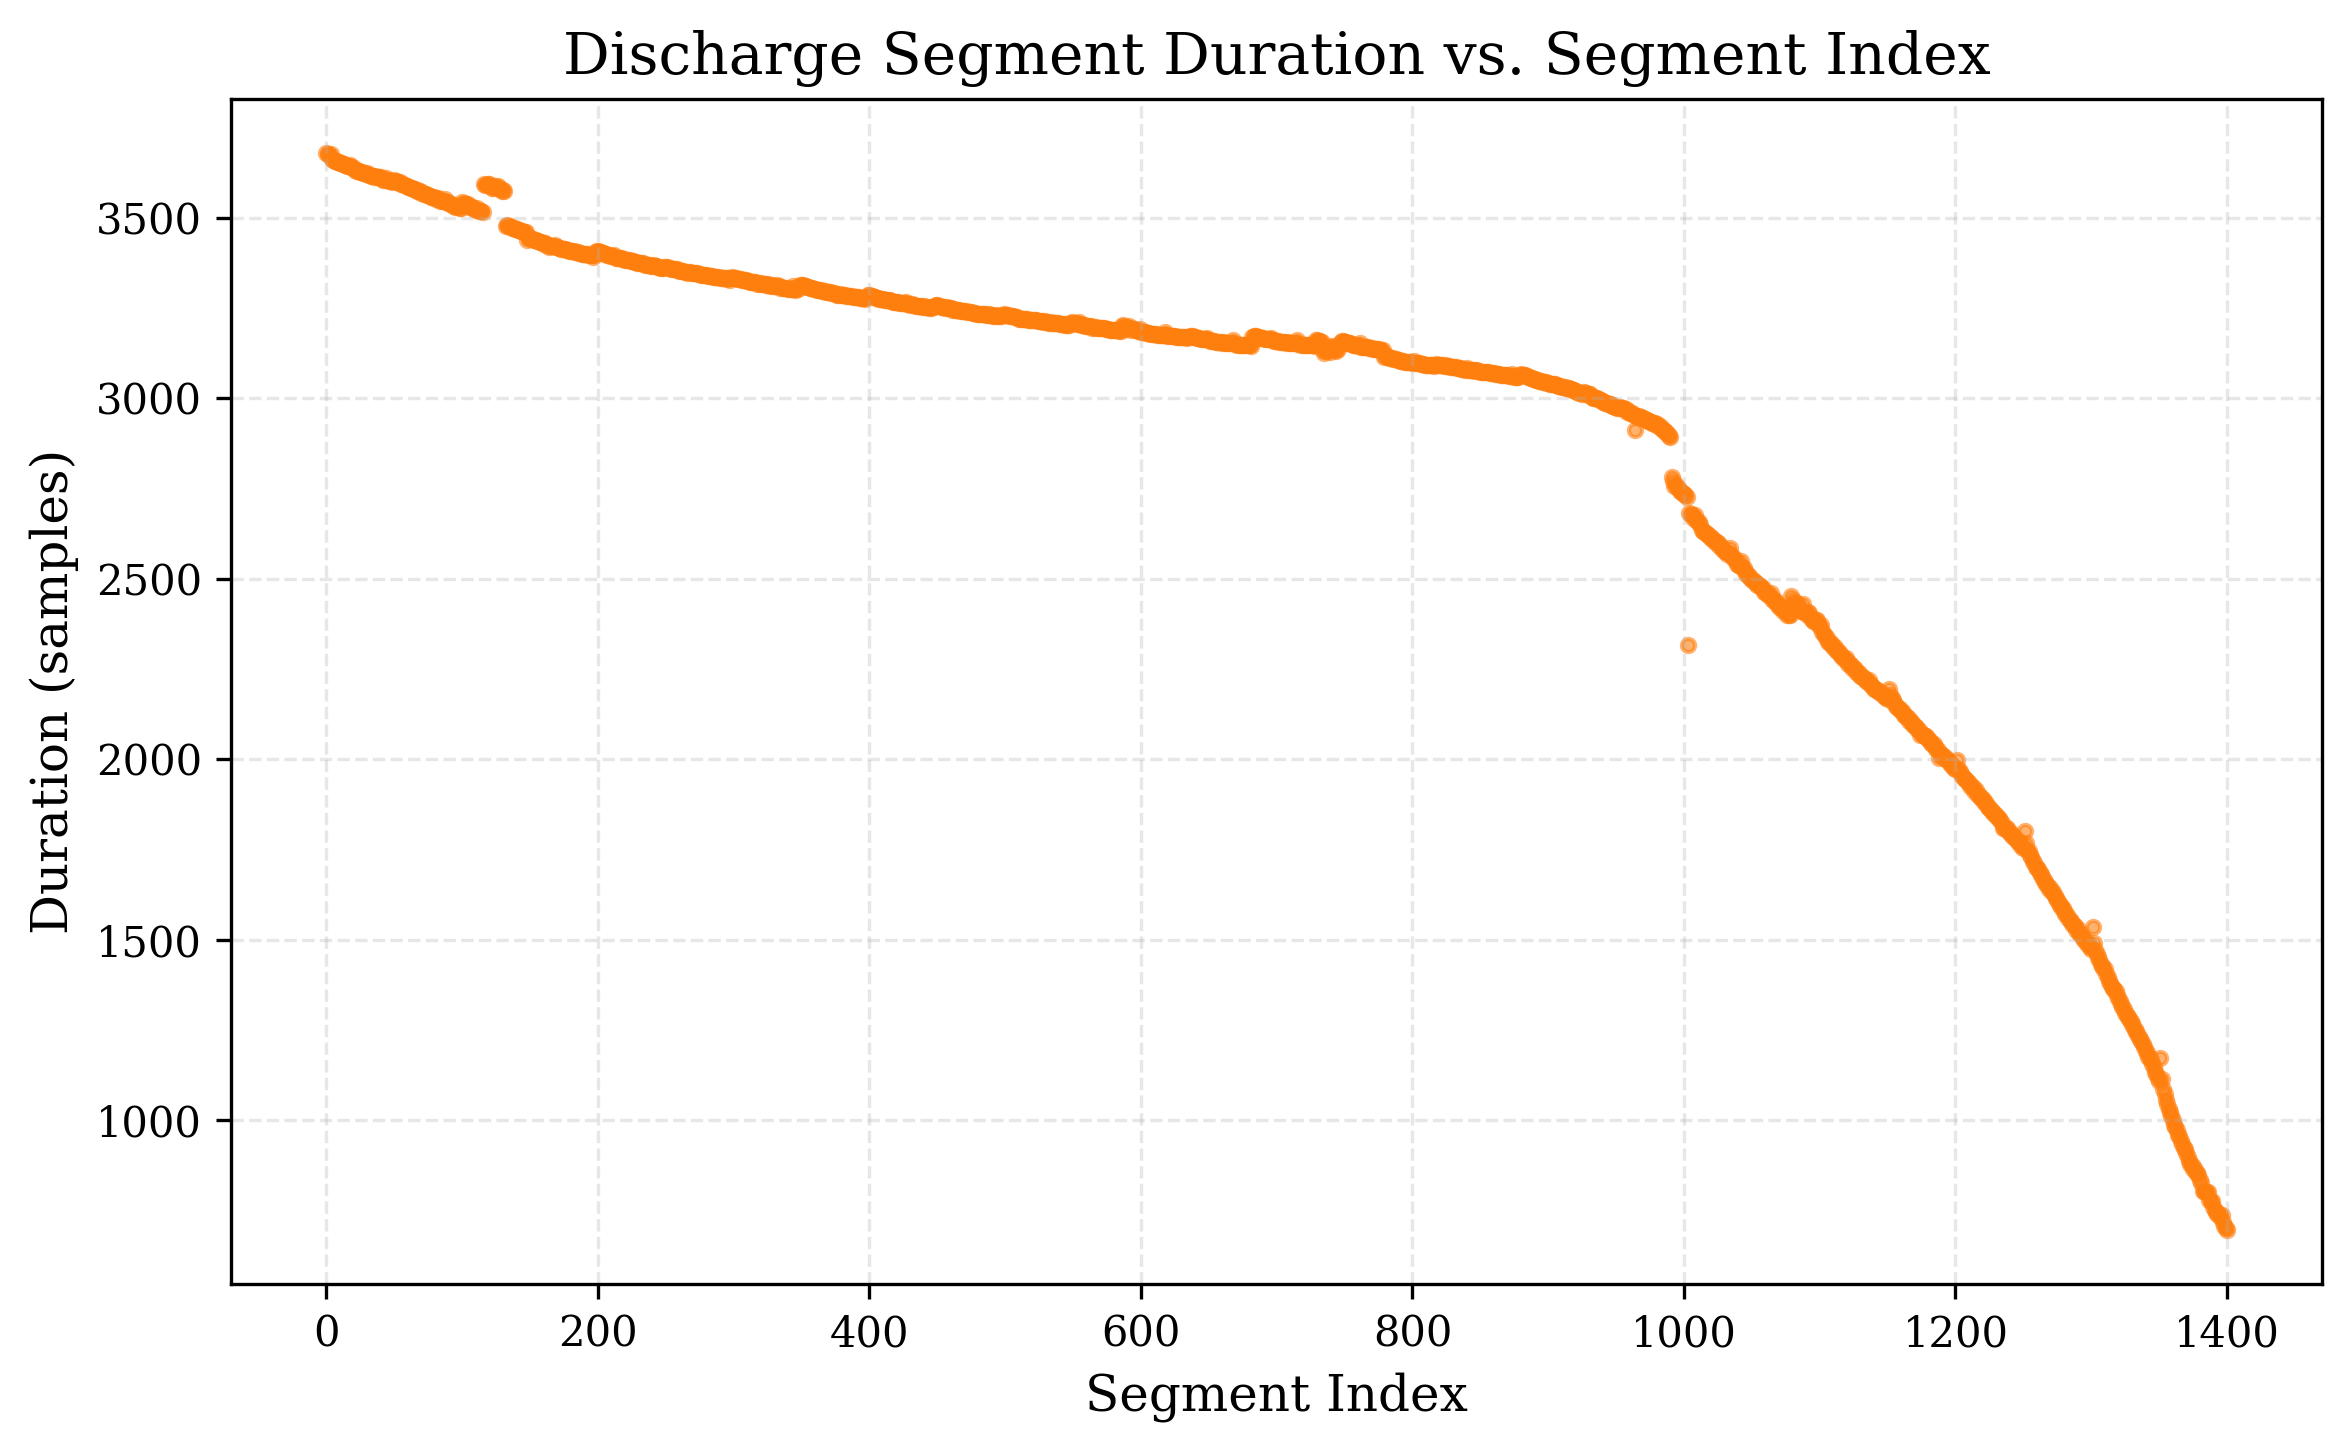

Plot saved to result/phase_1\plot\discharge_duration_vs_index.png


In [11]:
plt.figure(figsize=(8, 5))
plt.scatter(range(len(segment_durations)), segment_durations, s=10, alpha=0.6, color='tab:orange')
plt.xlabel('Segment Index')
plt.ylabel('Duration (samples)')
plt.title('Discharge Segment Duration vs. Segment Index')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "discharge_duration_vs_index.png"), bbox_inches='tight')
plt.show()

print(f"Plot saved to {os.path.join(PLOT_DIR, 'discharge_duration_vs_index.png')}")

## **1.8 Post-Process Segments (Filter by Minimal Duration/Magnitude; Index Integrity)**

In [ ]:
MIN_DURATION = 1800  # 1800 seconds (30 minutes) minimum
MIN_AVG_MAGNITUDE = 0.1  # Minimum average |current| in Amperes

filtered_cycles = []

for i in range(len(discharge_starts)):
    start_idx = discharge_starts[i]
    end_idx = discharge_ends[i]
    duration = end_idx - start_idx + 1
    
    # Filter by duration
    if duration < MIN_DURATION:
        continue
    
    # Extract segment current and check average magnitude
    segment_current = df.loc[start_idx:end_idx, 'Current'].values
    avg_magnitude = np.abs(segment_current).mean()
    
    # Filter by magnitude
    if avg_magnitude < MIN_AVG_MAGNITUDE:
        continue
    
    filtered_cycles.append({
        'cycle_idx': len(filtered_cycles) + 1,
        'start_idx': start_idx,
        'end_idx': end_idx,
        'duration': duration,
        'avg_current_magnitude': avg_magnitude
    })

print(f"Total segments detected: {len(discharge_starts)}")
print(f"Segments after filtering: {len(filtered_cycles)}")
print(f"Filtered out: {len(discharge_starts) - len(filtered_cycles)}")

print(f"\nFirst 10 filtered discharge cycles:")
for cycle in filtered_cycles[:10]:
    print(f"  Cycle {cycle['cycle_idx']}: start={cycle['start_idx']}, end={cycle['end_idx']}, "
          f"duration={cycle['duration']}s, avg_|I|={cycle['avg_current_magnitude']:.4f}A")

Total segments detected: 1401
Segments after filtering: 1241
Filtered out: 160

First 10 filtered discharge cycles:
  Cycle 1: start=12966, end=16645, duration=3680s, avg_|I|=3.1991A
  Cycle 2: start=29998, end=33673, duration=3676s, avg_|I|=3.1991A
  Cycle 3: start=47011, end=50685, duration=3675s, avg_|I|=3.1991A
  Cycle 4: start=64015, end=67690, duration=3676s, avg_|I|=3.1991A
  Cycle 5: start=81003, end=84665, duration=3663s, avg_|I|=3.1991A
  Cycle 6: start=97996, end=101656, duration=3661s, avg_|I|=3.1991A
  Cycle 7: start=114956, end=118612, duration=3657s, avg_|I|=3.1991A
  Cycle 8: start=131935, end=135591, duration=3657s, avg_|I|=3.1991A
  Cycle 9: start=148907, end=152560, duration=3654s, avg_|I|=3.1991A
  Cycle 10: start=165861, end=169516, duration=3656s, avg_|I|=3.1991A


## **1.9 Segmentation Filtering Impact**

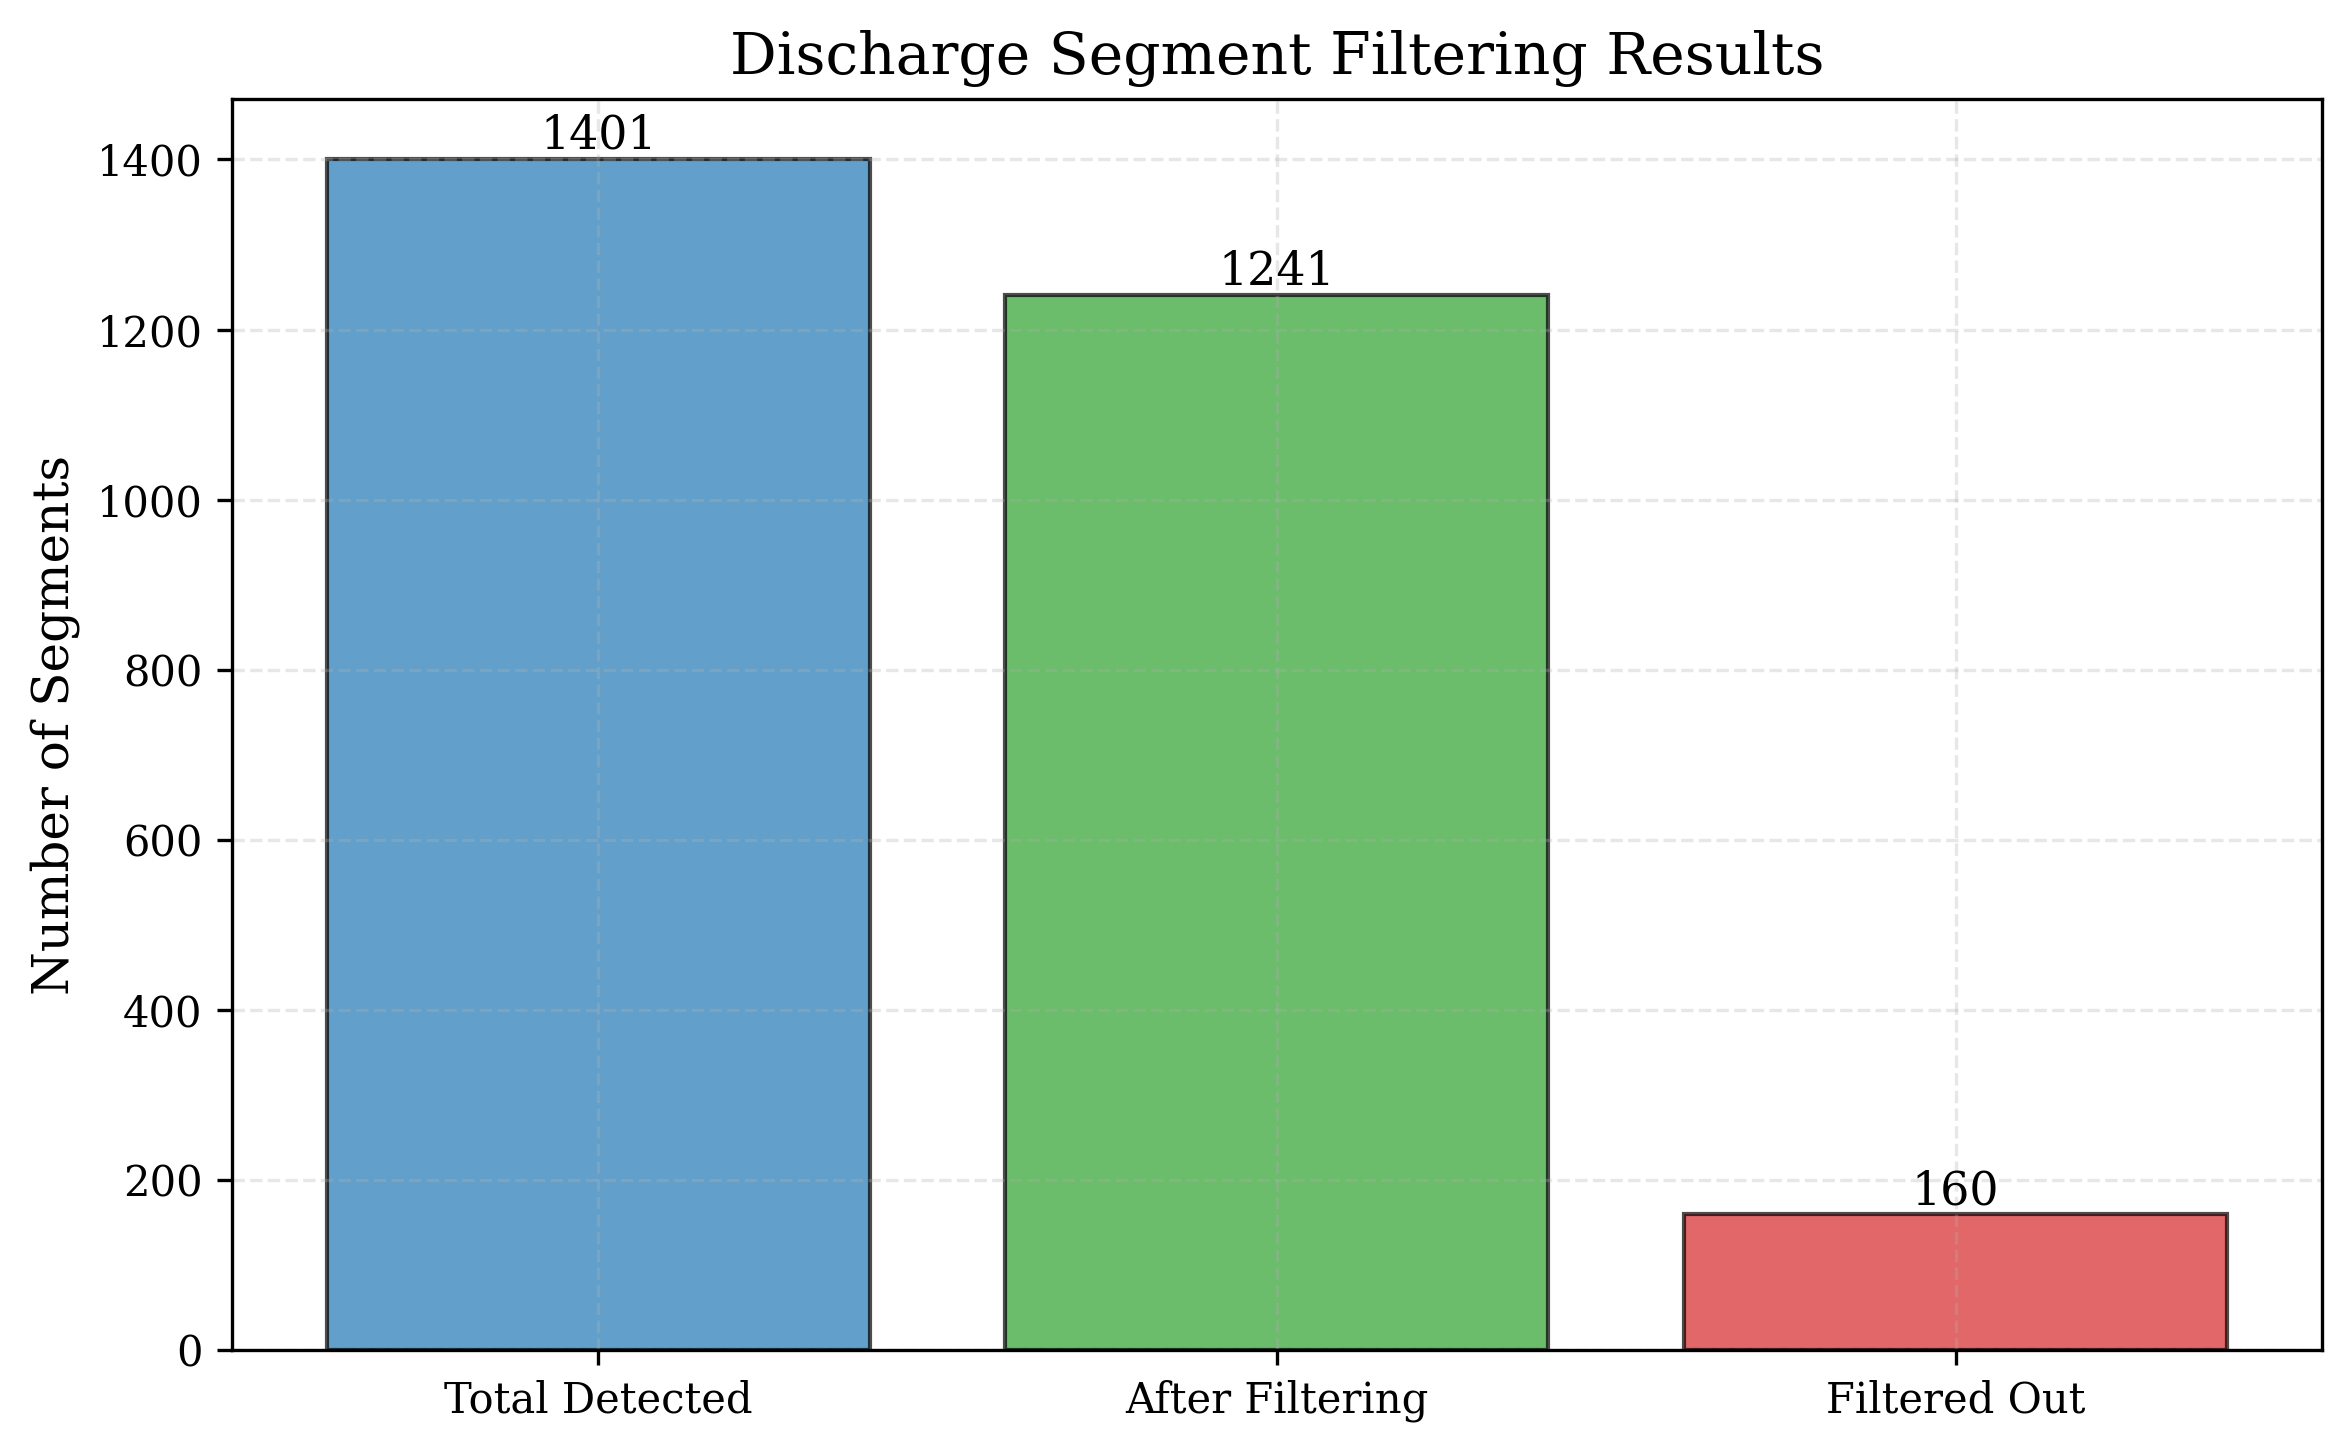

Plot saved to result/phase_1\plot\segmentation_filtering_impact.png


In [14]:
plt.figure(figsize=(8, 5))

categories = ['Total Detected', 'After Filtering', 'Filtered Out']
counts = [len(discharge_starts), len(filtered_cycles), len(discharge_starts) - len(filtered_cycles)]
colors = ['tab:blue', 'tab:green', 'tab:red']

bars = plt.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Number of Segments')
plt.title('Discharge Segment Filtering Results')
plt.grid(True, alpha=0.3, linestyle='--', axis='y')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "segmentation_filtering_impact.png"), bbox_inches='tight')
plt.show()

print(f"Plot saved to {os.path.join(PLOT_DIR, 'segmentation_filtering_impact.png')}")

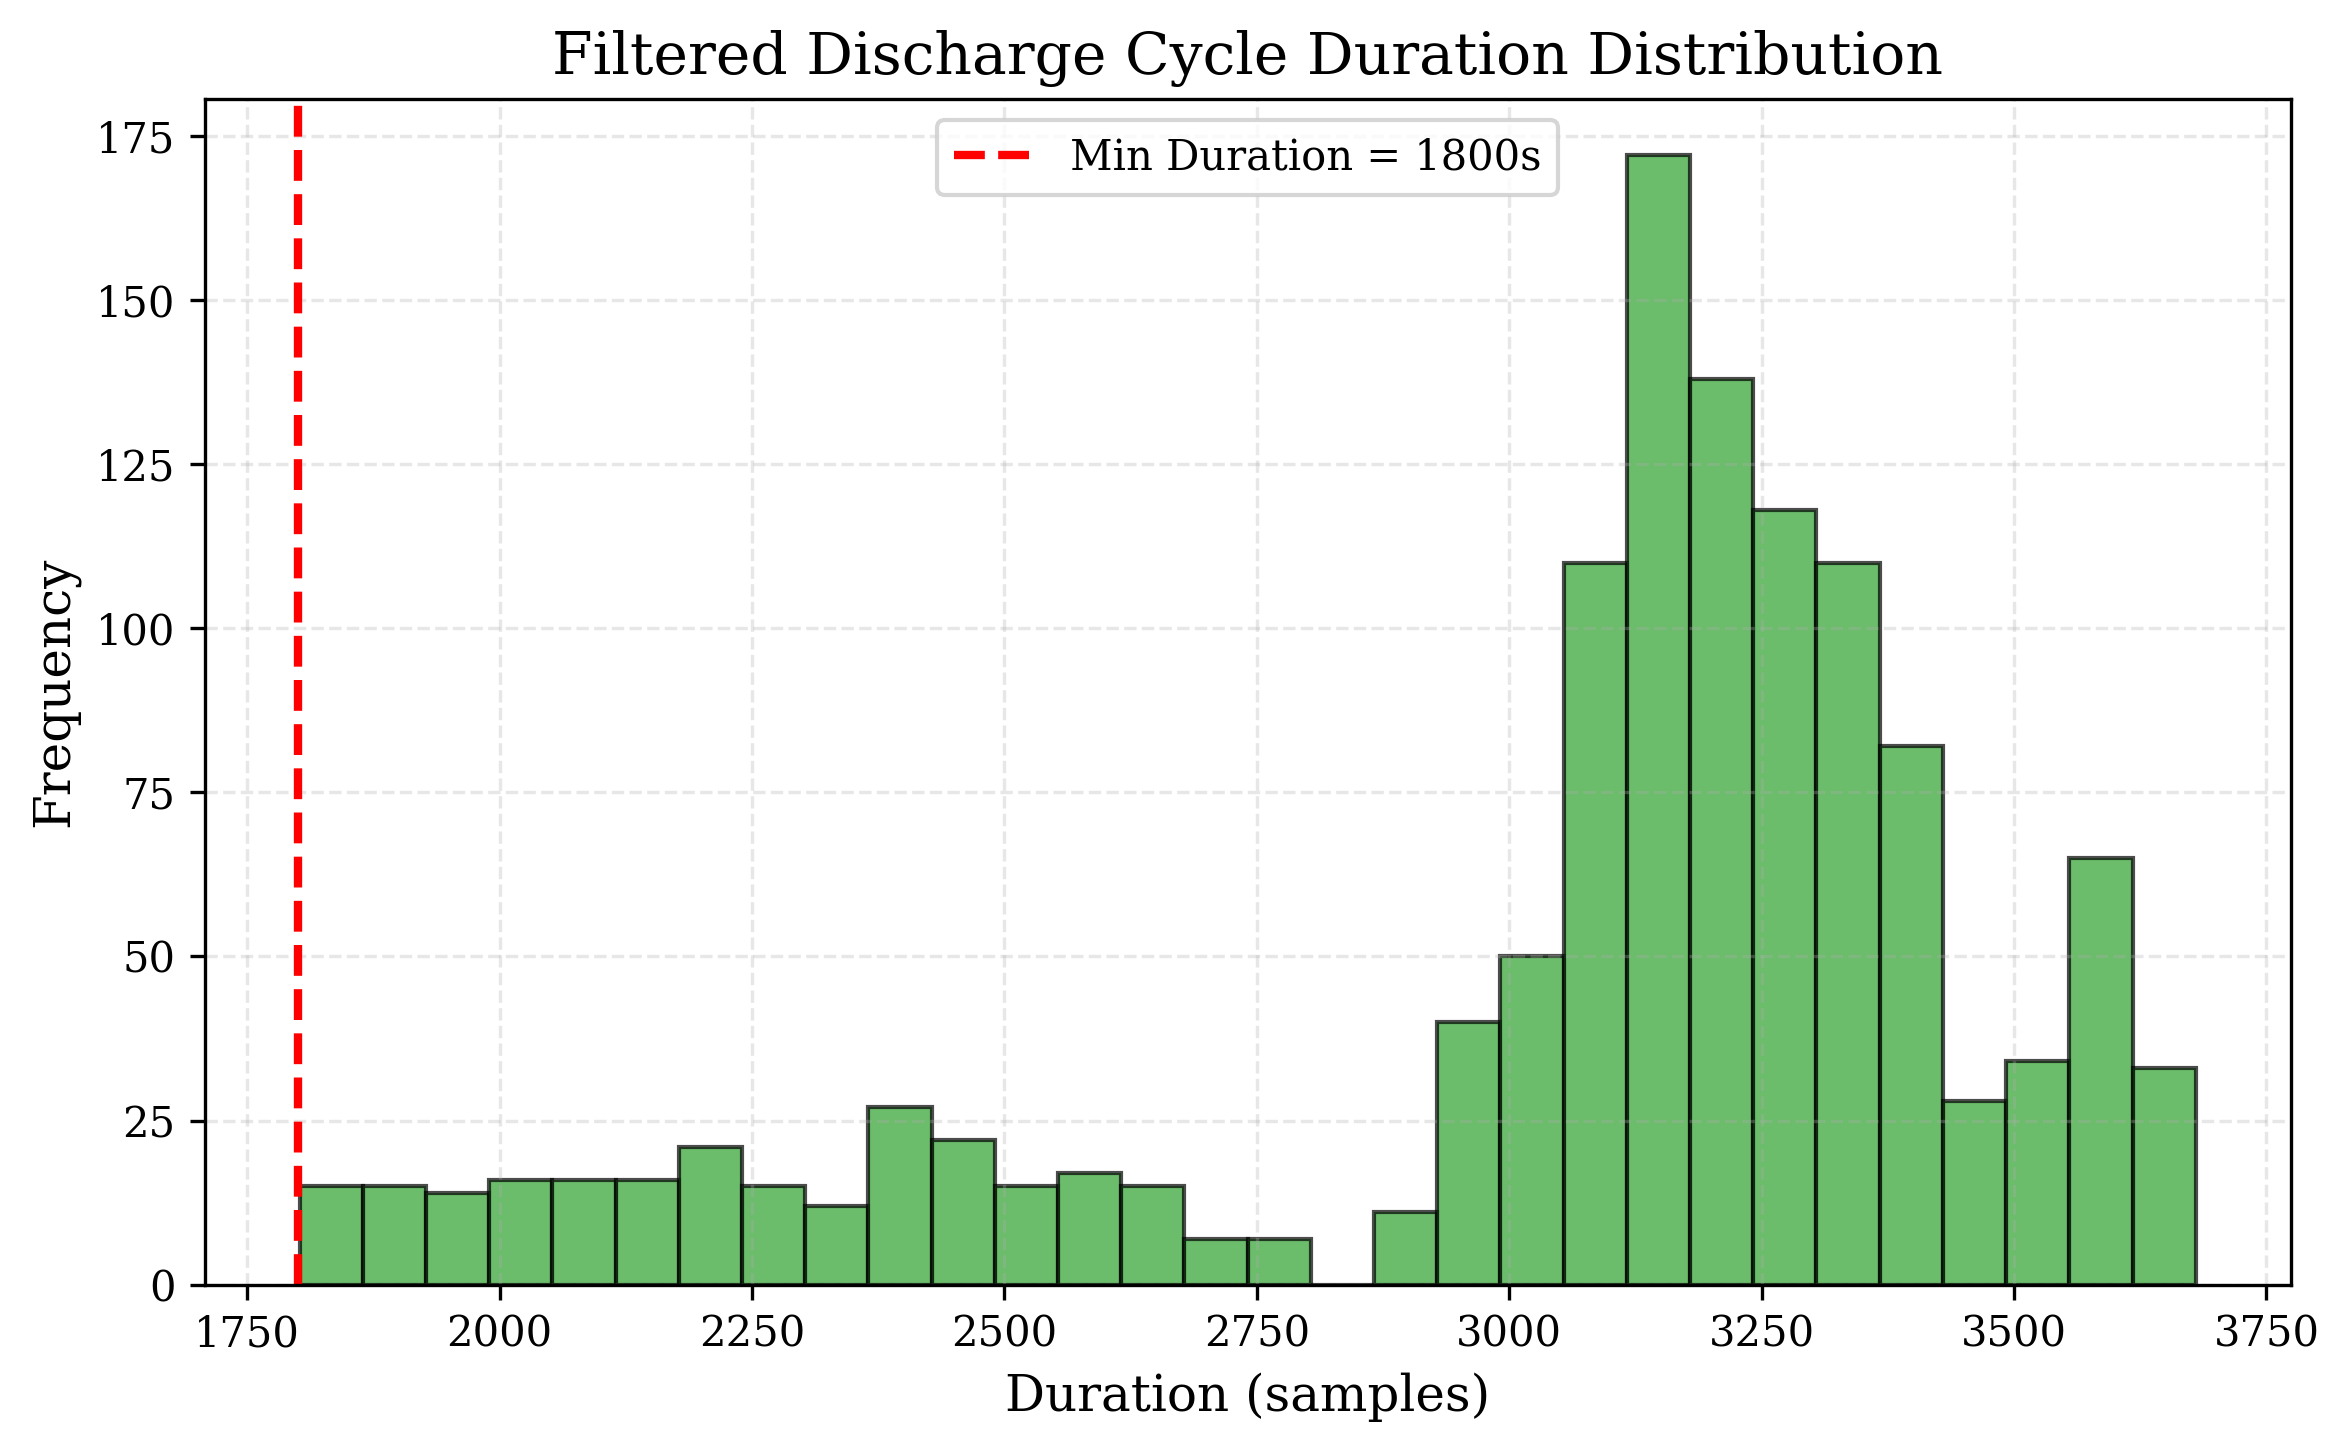

Plot saved to result/phase_1\plot\filtered_cycle_durations.png


In [15]:
filtered_durations = [cycle['duration'] for cycle in filtered_cycles]

plt.figure(figsize=(8, 5))
plt.hist(filtered_durations, bins=30, color='tab:green', alpha=0.7, edgecolor='black')
plt.xlabel('Duration (samples)')
plt.ylabel('Frequency')
plt.title('Filtered Discharge Cycle Duration Distribution')
plt.axvline(MIN_DURATION, color='red', linestyle='--', linewidth=2, label=f'Min Duration = {MIN_DURATION}s')
plt.legend()
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "filtered_cycle_durations.png"), bbox_inches='tight')
plt.show()

print(f"Plot saved to {os.path.join(PLOT_DIR, 'filtered_cycle_durations.png')}")

## **1.10 Save Segmentation**

In [16]:
cycles_path = os.path.join(DATA_DIR, 'cycles.pkl')
with open(cycles_path, 'wb') as f:
    pickle.dump(filtered_cycles, f)

print(f"Saved cycles to: {cycles_path}")
print(f"Total cycles saved: {len(filtered_cycles)}")

summary_df = pd.DataFrame(filtered_cycles)
summary_path = os.path.join(DATA_DIR, 'summary.csv')
summary_df.to_csv(summary_path, index=False)

print(f"\nSaved summary to: {summary_path}")
print(f"\nSummary statistics:")
print(f"  Total discharge cycles: {len(filtered_cycles)}")
print(f"  Duration range: {summary_df['duration'].min()}s to {summary_df['duration'].max()}s")
print(f"  Duration mean: {summary_df['duration'].mean():.1f}s")
print(f"  Avg current magnitude range: {summary_df['avg_current_magnitude'].min():.4f}A to {summary_df['avg_current_magnitude'].max():.4f}A")
print(f"  Avg current magnitude mean: {summary_df['avg_current_magnitude'].mean():.4f}A")

print("\nPhase 1 data preprocessing complete.")

Saved cycles to: result/phase_1\data\cycles.pkl
Total cycles saved: 1241

Saved summary to: result/phase_1\data\summary.csv

Summary statistics:
  Total discharge cycles: 1241
  Duration range: 1802s to 3680s
  Duration mean: 3061.2s
  Avg current magnitude range: 3.1981A to 3.1991A
  Avg current magnitude mean: 3.1989A

Phase 1 data preprocessing complete.
